In [63]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [36]:
df = pd.read_csv('.//AB_NYC_2019.csv')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [38]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

logit:根据客户喜爱程度，filter/classify data， 找到key element
    根据以上建模，预测price
Data Cleaning:
-replace NA value to 0
-drop id, host_id, host_name

Data scaning:
-plot all numberic vraibles relationship: scatter plot matrix(like R)


Data Analysis:
-Finding relationship between number of review, reviews_permonth, and availability_365 (continue with data scaning, sub plot or regression)

-using name columns: tokenized, anaylsis which character is more poppular to customer ((number of review) * (review per month) as temp popularity column)
--finding most popular 8 string first, and create new column
--ex: new column = 'Sunshie', if exist in value=1

-using latitude and longitude to separate housing to group: uptown, midtown, downtown, etc: check popularity based on location: avg price per night per group
-check price fluctuation based on location
-using regression analysis the relationship between popularity and interested factors
-which neighbourhood/group is most attractive [which is more accurate]
-review frequency and availability,( did the review are all come from extreem review, low availability may means high popularity)
-using new york city.png plot the desenty of airbnb listing

-Logistic reg: y=price, x =  attractive charactor in name, group, neigborhood, neighbourhood_group,minimum_nights
-classification based on name, find the frequency of character to predicted group


# 1) Wrangling and Cleaning the Data

In [39]:
df[df.host_name.isna()].sample(3)
#here, we can find that most nan value are in the column of last_review and review_per_month

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
8163,6292866,Modern Quiet Gem Near All,32722063,NaN,Brooklyn,East Flatbush,40.65263,-73.93215,Entire home/apt,85,2,182,2019-06-19,3.59,2,318
38992,30468335,LARGE Prospect Lefferts Gardens Bedroom,228750026,NaN,Brooklyn,Flatbush,40.65152,-73.95271,Private room,55,7,0,NaN,NaN,1,69
28274,21990808,***SLEEPING IN THE GOLDEN PLACE***,159156636,NaN,Manhattan,Hell's Kitchen,40.75835,-73.99065,Private room,120,1,88,2018-12-14,4.93,3,0


In [40]:
l = pd.DataFrame(df.name.value_counts())

print(l.loc[l.name <= 1].head())
print('\n')
print(f'the total number of the dataset : {len(l)}')

                                                   name
Luxurious Apt in the heart of Manhattan               1
Coworking Style Sublet                                1
Art Lover’s Loft on SoHo/Greenwich Village Border     1
East Harlem room                                      1
Humble and Elegant Place of Comfort                   1


the total number of the dataset : 47905


In [41]:
len(df.loc[df['number_of_reviews'] == 0 ])
# I find here, number_of_reviews are the coresponding value to reviews_per_month, and if
# number_of_reviews == 0, resulting in the reviews_per_month also == 0, so we can just
# assign 0 to the nan in the column of reviews_per_month

10052

### 一些小的想法，就是这里我们发现其实 name 应该代表着的就是公司名，我们是不是可以按照不同公司，名下的公寓数量进行一些分析呢？ host_name 应该指代的是每个特定的房东，会不会分析，每家公司的一些信息，我们也可以发现一些比较好玩的东西。

In [42]:
df.fillna({'reviews_per_month':0}, inplace=True) # replace the nan value in reviews_per_month with 0

In [43]:
df['last_review'] = pd.to_datetime(df['last_review']) # convert the last_review's type to Timestamp
df.last_review.isna().sum()

10052

In [44]:
df.dropna(axis = 0,subset= ['name', 'host_name'], inplace= True) # drop non-significant NaN value in 'name' and 'host_name'

len(df)


48858

In [45]:
df1 = df.drop(columns = ['id', 'host_id','name','host_name','last_review'])

len(df1)

# the back-up dataset for some targets

48858

In [46]:
df1['neighbourhood_group']= df1['neighbourhood_group'].astype("category").cat.codes
df1['neighbourhood'] = df1['neighbourhood'].astype("category").cat.codes
df1['room_type'] = df1['room_type'].astype("category").cat.codes

# convert the cateforical features to int features, for the convinience of doing machine learning later

# 2) Data Exploratory Analysis on price

### a) the normal plot of 'price'

/Users/anthony/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Price Distribution Plot')

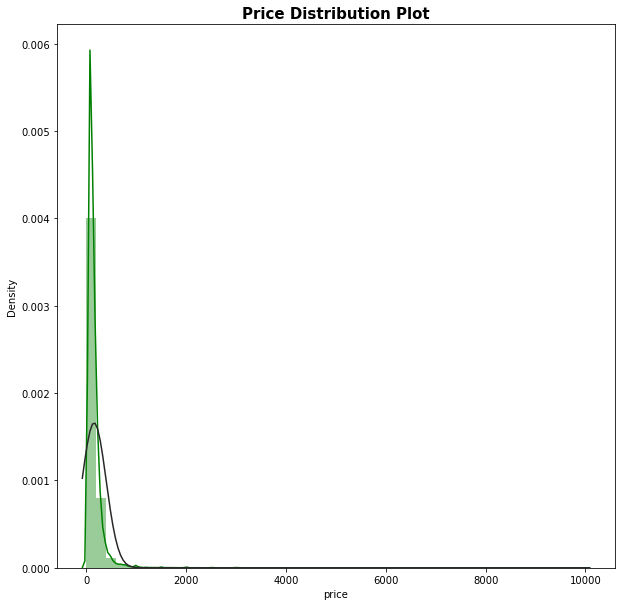

In [47]:
plt.figure(figsize=(10,10))

sns.distplot(df1['price'], fit=norm, color='g')

plt.title("Price Distribution Plot",size=15, weight='bold')

In [48]:
# Create a new column 'price_dummy' in df1 based on the median price
df1['price_dummy'] = [0 if x < df['price'].median() else 1 for x in df['price']]

#### we also find that this bell-shape distribution of price have skewness on the right side too much, so we would logalize the price to make it more normal

In [49]:
df1['price_log'] = np.log(df1.price + 1) # add 1 to avoid the appearance of log0

/Users/anthony/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'price_log Distribution Plot')

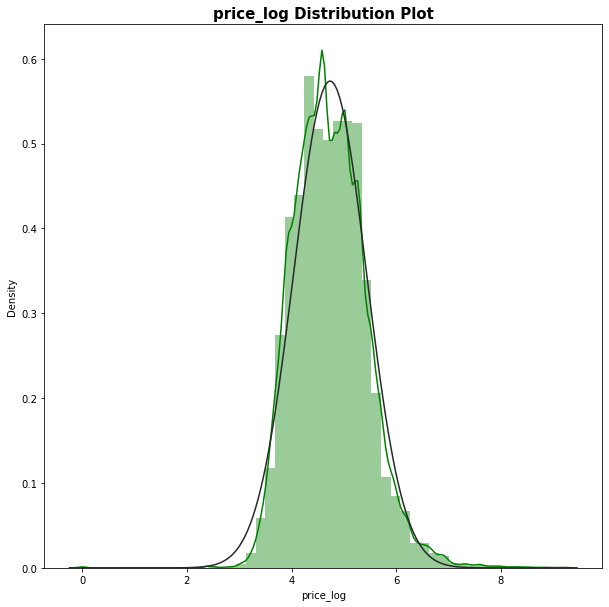

In [50]:
plt.figure(figsize=(10,10))

sns.distplot(df1['price_log'], fit=norm, color='g')

plt.title("price_log Distribution Plot",size=15, weight='bold')


### b) Q-Q plot of 'price_log'

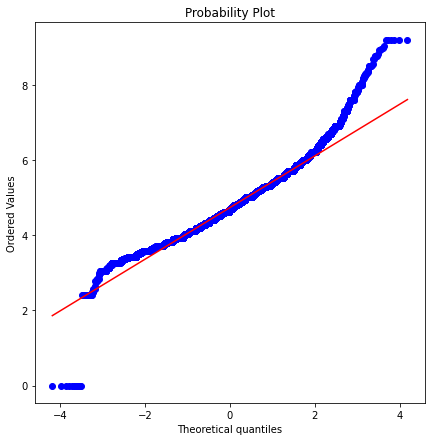

In [51]:
# Draw the Q-Q plot, which reveal the normality of 'price_log'

plt.figure(figsize=(7,7))

stats.probplot(df1['price_log'], plot=plt)

plt.show()

In [52]:
df1.drop(columns=['price'],inplace= True)
df1.columns


Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'price_dummy',
       'price_log'],
      dtype='object')

### c) scatter_plot between each feature and correlation plot

array([[<AxesSubplot:xlabel='neighbourhood_group', ylabel='neighbourhood_group'>,
        <AxesSubplot:xlabel='neighbourhood', ylabel='neighbourhood_group'>,
        <AxesSubplot:xlabel='latitude', ylabel='neighbourhood_group'>,
        <AxesSubplot:xlabel='longitude', ylabel='neighbourhood_group'>,
        <AxesSubplot:xlabel='room_type', ylabel='neighbourhood_group'>,
        <AxesSubplot:xlabel='minimum_nights', ylabel='neighbourhood_group'>,
        <AxesSubplot:xlabel='number_of_reviews', ylabel='neighbourhood_group'>,
        <AxesSubplot:xlabel='reviews_per_month', ylabel='neighbourhood_group'>,
        <AxesSubplot:xlabel='calculated_host_listings_count', ylabel='neighbourhood_group'>,
        <AxesSubplot:xlabel='availability_365', ylabel='neighbourhood_group'>,
        <AxesSubplot:xlabel='price_dummy', ylabel='neighbourhood_group'>,
        <AxesSubplot:xlabel='price_log', ylabel='neighbourhood_group'>],
       [<AxesSubplot:xlabel='neighbourhood_group', ylabel='neighbourhoo

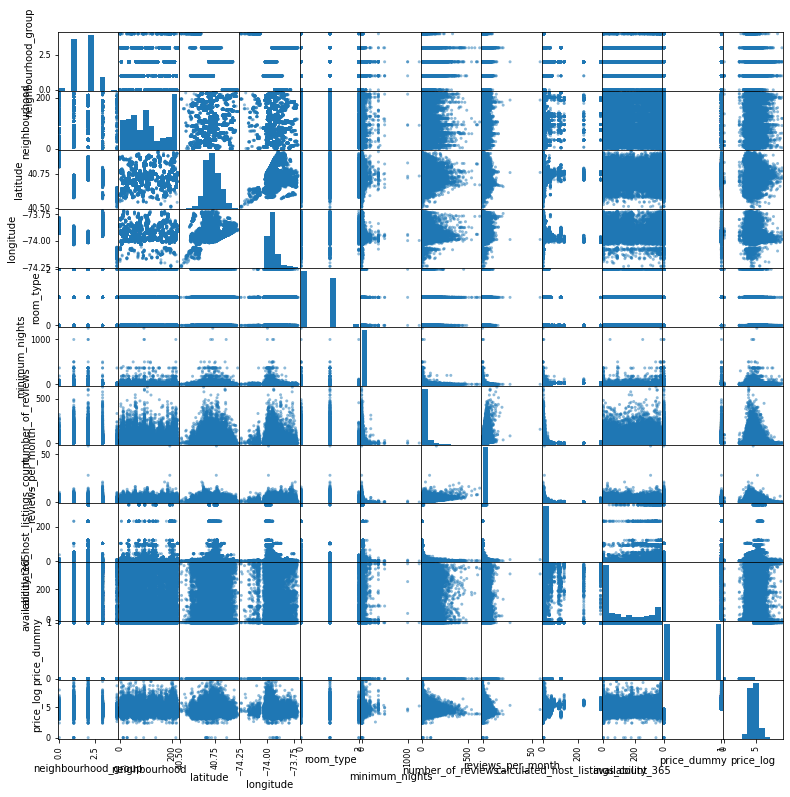

In [53]:
pd.plotting.scatter_matrix(df1,figsize=(13, 13))

#### Provide the correlation between each feature

Text(0.5, 1.0, 'Correlation Matrix')

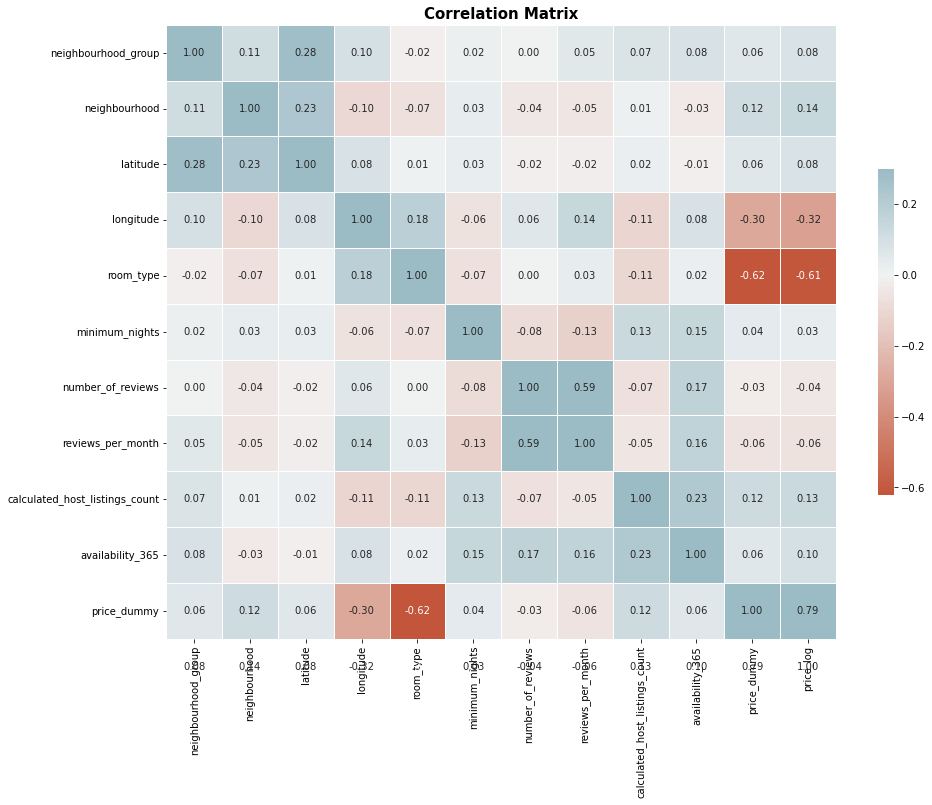

In [54]:
plt.figure(figsize=(15,12))

palette = sns.diverging_palette(20, 220, n=256)

corr=df1.corr(method='pearson')

sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(11, 0))

plt.title("Correlation Matrix",size=15, weight='bold')

#### then, we also need to detect the outlier and linearity between price_log and other features, by Residual-Plots

/Users/anthony/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/anthony/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/anthony/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

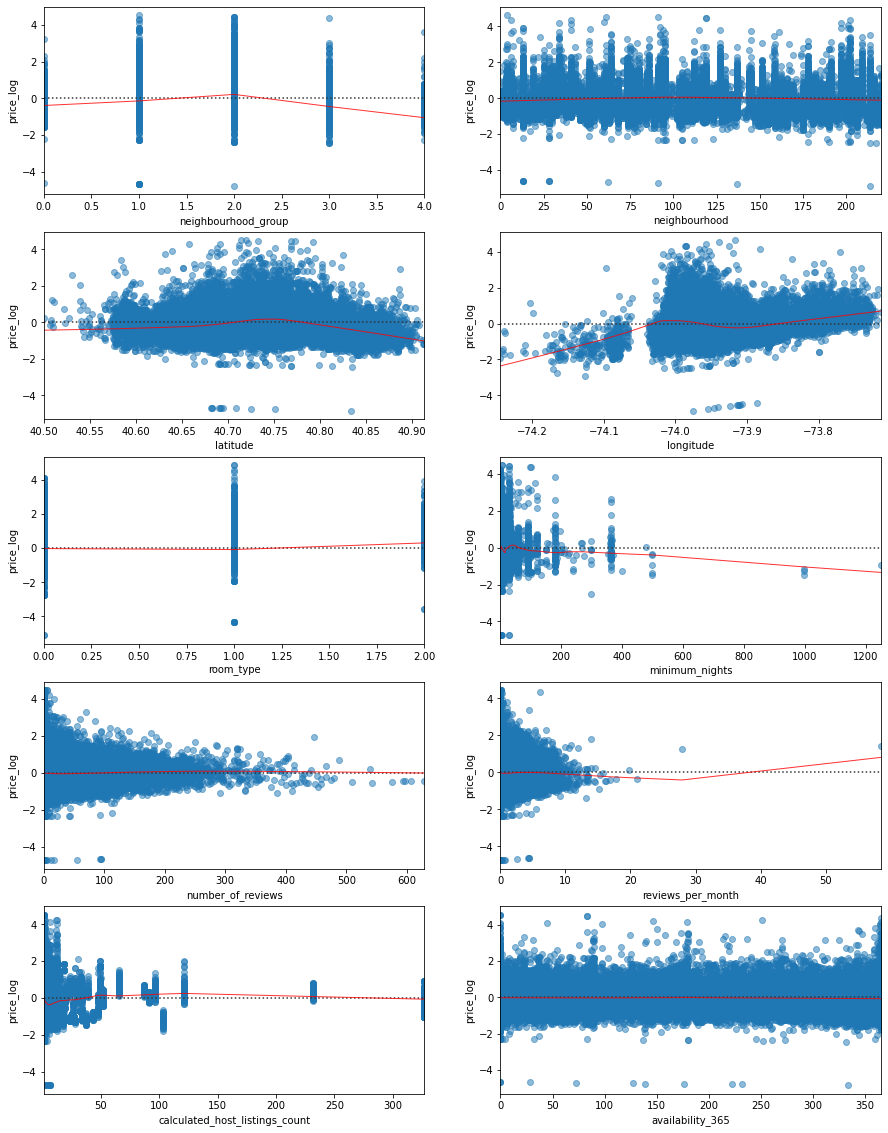

In [55]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

index = 0

for i in range(5):
    for j in range(2):

        sns.residplot(df1.iloc[:,index],df1.iloc[:,-1],
                      lowess=True, ax=axes[i, j], scatter_kws={'alpha': 0.5},
                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
        index += 1




# 3) Compare different models upon predicting price

### a) Set up training and test sets

In [56]:
# split data into training and test sets
X = df1[['neighbourhood_group','neighbourhood','room_type','minimum_nights','number_of_reviews',
         'reviews_per_month','calculated_host_listings_count','availability_365']]
y1 = df1['price_log']
y2 = df1['price_dummy']
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size = 0.2, random_state = 100)

### b) Predict 'price_log'

In [57]:
# Initialize the models
linear = LinearRegression()
lasso = Lasso()
ridge = Ridge()
gbr = GradientBoostingRegressor()
# Train the models
linear.fit(X_train, y1_train)
lasso.fit(X_train, y1_train)
ridge.fit(X_train, y1_train)
gbr.fit(X_train, y1_train)
# Predict prices on the test set
linear_pred = linear.predict(X_test)
lasso_pred = lasso.predict(X_test)
ridge_pred = ridge.predict(X_test)
gbr_pred = gbr.predict(X_test)
# Calculate mean squared error and R^2 score
linear_MSE = mean_squared_error(y1_test, gbr_pred)
lasso_MSE = mean_squared_error(y1_test, lasso_pred)
ridge_MSE = mean_squared_error(y1_test, ridge_pred)
gbr_MSE = mean_squared_error(y1_test, gbr_pred)
linear_R2 = r2_score(y1_test, linear_pred)
lasso_R2 = r2_score(y1_test, lasso_pred)
ridge_R2 = r2_score(y1_test, ridge_pred)
gbr_R2 = r2_score(y1_test, gbr_pred)
print("Linear Regression: MSE = {:.2f}, R^2 = {:.2f}".format(linear_MSE, linear_R2))
print("Lasso Regression: MSE = {:.2f}, R^2 = {:.2f}".format(lasso_MSE, lasso_R2))
print("Ridge Regression: MSE = {:.2f}, R^2 = {:.2f}".format(ridge_MSE, ridge_R2))
print("Gradient Boosting Regression: MSE = {:.2f}, R^2 = {:.2f}".format(gbr_MSE, gbr_R2))

Linear Regression: MSE = 0.21, R^2 = 0.41
Lasso Regression: MSE = 0.46, R^2 = 0.04
Ridge Regression: MSE = 0.28, R^2 = 0.41
Gradient Boosting Regression: MSE = 0.21, R^2 = 0.56


### c) Predict 'price_dummy'

In [58]:
# Initialize the models
linear = LinearRegression()
lasso = Lasso()
logit = LogisticRegression()
ridge_clf = RidgeClassifier()
gb_clf = GradientBoostingClassifier()
# Train the models
linear.fit(X_train, y2_train)
lasso.fit(X_train, y2_train)
logit.fit(X_train, y2_train)
ridge_clf.fit(X_train, y2_train)
gb_clf.fit(X_train, y2_train)
# Predict prices on the test set
linear_pred = linear.predict(X_test)
lasso_pred = lasso.predict(X_test)
logit_pred = logit.predict(X_test)
ridge_clf_pred = ridge_clf.predict(X_test)
gb_clf_pred = gb_clf.predict(X_test)
# Apply threshold to convert continuous predictions to binary classes
threshold = 0.5
linear_clf_pred = (linear_pred > threshold).astype(int)
lasso_clf_pred = (lasso_pred > threshold).astype(int)
#accuracy_score
linear_accuracy = accuracy_score(y2_test, linear_clf_pred)
lasso_accuracy = accuracy_score(y2_test, lasso_clf_pred)
logit_accuracy = accuracy_score(y2_test, logit_pred)
ridge_accuracy = accuracy_score(y2_test, ridge_clf_pred)
gb_accuracy = accuracy_score(y2_test, gb_clf_pred)
print(f'Accuracy: {linear_accuracy}')
print(f'Accuracy: {lasso_accuracy}')
print(f'Accuracy: {logit_accuracy}')
print(f'Accuracy: {ridge_accuracy}')
print(f'Accuracy: {gb_accuracy}')
#f1_score
linear_f1 = f1_score(y2_test, linear_clf_pred)
lasso_f1 = f1_score(y2_test, lasso_clf_pred)
logit_f1 = f1_score(y2_test, logit_pred)
ridge_f1 = f1_score(y2_test, ridge_clf_pred)
gb_f1 = f1_score(y2_test, gb_clf_pred)
print(f'f1: {linear_f1}')
print(f'f1: {lasso_f1}')
print(f'f1: {logit_f1}')
print(f'f1: {ridge_f1}')
print(f'f1: {gb_f1}')

/Users/anthony/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8200982398690135
Accuracy: 0.5497339336880884
Accuracy: 0.8195865738845681
Accuracy: 0.8200982398690135
Accuracy: 0.8291035611952517
f1: 0.825248508946322
f1: 0.5253505933117584
f1: 0.8247340689929417
f1: 0.825248508946322
f1: 0.832598235765838


### d) Compare models

In [59]:
# Collect model names, accuracy, and F1 scores
models_1 = ['Linear', 'Lasso', 'Ridge', 'Gradient Boost']
models_2 = ['Linear', 'Lasso', 'Logistic', 'Ridge', 'Gradient Boost']
MSEs = [linear_MSE, lasso_MSE, ridge_MSE, gbr_MSE]
R2s = [linear_R2, lasso_R2, ridge_R2, gbr_R2]
accuracy_scores = [linear_accuracy, lasso_accuracy, logit_accuracy, ridge_accuracy, gb_accuracy]
f1_scores = [linear_f1, lasso_f1, logit_f1, ridge_f1, gb_f1]

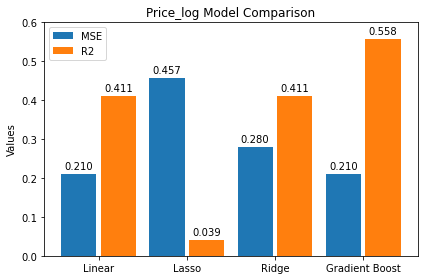

In [60]:
# Set up the plot
x = np.arange(len(models_1))
width = 0.4
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2 - 0.025, MSEs, width, label='MSE')
rects2 = ax.bar(x + width/2 + 0.025, R2s, width, label='R2')

# Add labels, title and custom x-axis tick labels
ax.set_ylabel('Values')
ax.set_title('Price_log Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models_1)
ax.legend()
ax.set_ylim(0, 0.6)
# Create a function to display the values on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

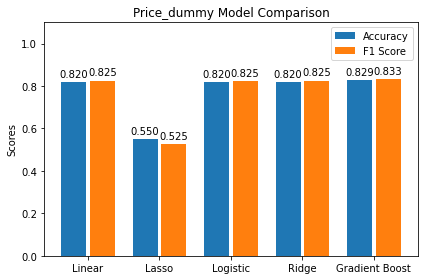

In [61]:
# Set up the plot
x = np.arange(len(models_2))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2 - 0.025, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x + width/2 + 0.025, f1_scores, width, label='F1 Score')

# Add labels, title and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Price_dummy Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1.1)
# Create a function to display the values on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

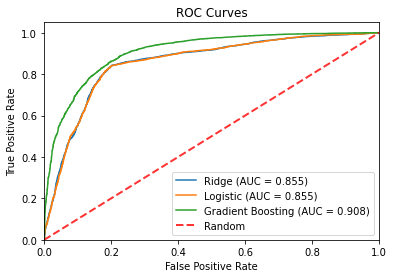

In [64]:
# Compute ROC curve and AUC for RidgeClassifier
ridge_probs = ridge_clf.decision_function(X_test)
ridge_fpr, ridge_tpr, _ = roc_curve(y2_test, ridge_probs)
ridge_auc = auc(ridge_fpr, ridge_tpr)

# Compute ROC curve and AUC for Logistic Regression
logistic_probs = logit.predict_proba(X_test)[:, 1]
logistic_fpr, logistic_tpr, _ = roc_curve(y2_test, logistic_probs)
logistic_auc = auc(logistic_fpr, logistic_tpr)

# Compute ROC curve and AUC for Gradient Boosting Classifier
gb_probs = gb_clf.predict_proba(X_test)[:, 1]
gb_fpr, gb_tpr, _ = roc_curve(y2_test, gb_probs)
gb_auc = auc(gb_fpr, gb_tpr)

# Plot ROC curves
plt.figure()
plt.plot(ridge_fpr, ridge_tpr, label='Ridge (AUC = {:.3f})'.format(ridge_auc))
plt.plot(logistic_fpr, logistic_tpr, label='Logistic (AUC = {:.3f})'.format(logistic_auc))
plt.plot(gb_fpr, gb_tpr, label='Gradient Boosting (AUC = {:.3f})'.format(gb_auc))

# Plot the random classifier (diagonal line)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=0.8)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()